In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
from statannot import add_stat_annotation
from matplotlib import pyplot as plt
from pltconfig import *

In [2]:
# Fig2S2: replicates and stats for CCMB1:pCB'+pCCM' growth in ambient air 
# in the bioreactor and also in a plate reader.

# Continuous data from photobioreactor (no lights) from 08/31/19.
# Growth curves are smoother but slower than continuous data from Spark.
# Note: first 19 rows are metadata for the experiment.
bioreactor_continuous_df = pd.read_csv('data/fig3/083119_CCMB1_bioreactor_continuous.csv', skiprows=19)
# Column names have whitespace off the machine
bioreactor_continuous_df.columns = [x.strip() for x in bioreactor_continuous_df.columns]

In [3]:
bioreactor_mapping = {'recon.1': 'od-sensors-1.od-680 ',  # reconstituted CCM
                      'recon.2': 'od-sensors-2.od-680 ',
                      'recon.4': 'od-sensors-3.od-680 ',
                      'K194M.3': 'od-sensors-4.od-680 ',  # rubisco active site mutant
                      'K194M.4': 'od-sensors-5.od-680 ',
                      'lsPrk.3': 'od-sensors-6.od-680 ',  # rubisco + prk alone
                      'lsPrk.4': 'od-sensors-7.od-680 ',
                      'pos.1': 'od-sensors-8.od-680 ',    # positive control
                     }
bioreactor_names2plot = dict()

# Set colors for for each curve
# - greens for rubisco+prk
# - purples for CCM
# - black for the positive control
# NOTE: not plotting negative controls because they overlap with "rubisco alone."
# Omitting positive control because I want to zoom in the on the part of the timecourse
# where the reconstituted CCM enables growth
for k, v in bioreactor_mapping.items():
    name, n = k.split('.')
    if name == 'K194M' or name == 'pos':
        # not plotting the controls
        continue 
        
    n = int(n)
    c = purples[-n]
    if name == 'lsPrk':
        c = greys[-n]

    bioreactor_names2plot[k] = c

In [4]:
# Continuous data from 08/31/19 spark experiment.
spark_cont_df = pd.read_csv('data/sup_figs/083119_spark_m9glycerol_ambient_raw.csv')

# Smooth data by 2x windowed mean twice over a 3 measurement window
# Note: data is not blanked since I am not calculating any rates in this plot, just raw measurements from the Spark. 
od_cols = spark_cont_df.columns[1:-1]
smoothed_df = spark_cont_df.copy()
smoothed_df[od_cols] = smoothed_df[od_cols].rolling(3, min_periods=1).apply(np.nanmean)
smoothed_df[od_cols] = smoothed_df[od_cols].rolling(3, min_periods=1).apply(np.nanmean)

# Column names for plotting below.
rub_alone_bio_reps = ['lsPrk.3', 'lsPrk.4'] # two bio replicates
full_ccm_bio_reps = ['rec.%d.1' % i for i in [1,2,4]] # 3 bio replicates

smoothed_df.head()

,Unnamed: 0,rec.1,rec.2,rec.4,rec.4.1,K194.3,K194.4,lsPrk.3,lsPrk.4,rec.1.1,...,lsPrk.4.10,rec.1.11,rec.2.11,rec.4.22,rec.4.23,K194.3.11,K194.4.11,lsPrk.3.11,lsPrk.4.11,time_s
0,0,0.047100,0.046180,0.048100,0.047080,0.048580,0.047240,0.049720,0.049080,0.048520,...,0.050300,0.050200,0.050280,0.049420,0.049720,0.050620,0.051940,0.050400,0.050560,0.000
1,1,0.047780,0.046850,0.049365,0.047990,0.048875,0.047615,0.049830,0.049770,0.048405,...,0.051325,0.053800,0.052980,0.051610,0.051920,0.051970,0.053785,0.050945,0.051910,1897.845
2,2,0.048718,0.047773,0.050643,0.049020,0.049692,0.048481,0.049938,0.050347,0.048566,...,0.052183,0.055964,0.054429,0.052987,0.053456,0.053564,0.055148,0.051599,0.052969,3795.547
3,3,0.051300,0.049536,0.053837,0.051904,0.052050,0.050768,0.050202,0.051798,0.049317,...,0.054688,0.061216,0.058160,0.056731,0.057840,0.057564,0.059723,0.053057,0.055776,5693.265
4,4,0.054773,0.051571,0.057667,0.056316,0.056596,0.054976,0.050476,0.053284,0.051427,...,0.057718,0.065824,0.061260,0.059833,0.062831,0.061649,0.064584,0.054684,0.058689,7590.925


In [5]:
# Endpoint data from 08/31/19 spark experiment. Produced from continuous data, endpoint is 80h. 
spark_endpoint_df = pd.read_csv('data/fig3/083119_CCMB1_ambient_OD80hrs_spark_blanked.csv', index_col=0, skipinitialspace=True)

# Groupings of samples for plotting spark endpoint data
all_names = spark_endpoint_df.replicate.unique()
exp = [c for c in all_names if c.startswith('rec')]
neg = [c for c in all_names if c.startswith('K194')]
neg_exp = [c for c in all_names if c.startswith('ls')]

# Colors to use for the spark endpoint data
replicates_palette = {}
replicates_palette.update([(n, greys[-1*i-1]) for i, n in enumerate(neg)])
replicates_palette.update([(n, greys[-1*i-1]) for i, n in enumerate(neg_exp)])
replicates_palette.update([(n, purples[-1*i-1]) for i, n in enumerate(exp)])

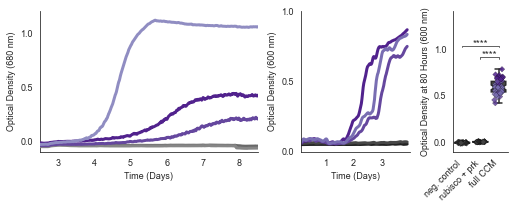

In [6]:
# Fig2S2 shows replicated data for CCMB1:pCB'+pCCM' in the bioreactor
# and also in the plate reader.
plt.figure(figsize=(7.25, 3))
sns.set_style('white')

gs = plt.GridSpec(1, 3, width_ratios=[4, 2, 1])

ax0 = plt.subplot(gs[0, 0])

for name, color in sorted(bioreactor_names2plot.items()):
    # 'key' is the name of the measurement/well we are looking at. 
    key = bioreactor_mapping[name]
    my_tube = bioreactor_continuous_df[bioreactor_continuous_df['key'] == key]
    
    # smooth the curves for plotting.
    times = my_tube.time.values
    ods = pd.Series(my_tube.value.values)
    median_filtered_ods = ods.rolling(5).median()
    smoothed_ods = median_filtered_ods.rolling(10).mean()
    z = 10
    if key.startswith('pos'):
        z = -10
    plt.plot(times, smoothed_ods, lw=3, color=color, zorder=z)
    
plt.xticks(np.arange(0, 216, 24), np.arange(0, 220, 24)//24, fontsize=9)
plt.yticks(np.arange(0.0, 1.01, 0.5), fontsize=9)

plt.xlim(60, 204)
plt.ylim(-0.1, 1.21)

plt.xlabel('Time (Days)', fontsize=9)
plt.ylabel('Optical Density (680 nm)', fontsize=9)

sns.despine(right=True, top=True, ax=ax0)

# Continuous data for calculating statistical significance. 
# Plotting only biological replicates - have many more technical ones.
ax1 = plt.subplot(gs[0, 1])
time_h = smoothed_df.time_s / (60*60)

for i, name in enumerate(rub_alone_bio_reps):
    c = greys[-i-1]
    plt.plot(time_h, smoothed_df[name], color=c, lw=3)

for i, name in enumerate(full_ccm_bio_reps):
    c = purples[-i-1]
    plt.plot(time_h, smoothed_df[name], color=c, lw=3)

plt.xticks(np.arange(0, 24*4+1, 24), np.arange(0, 4), fontsize=9)
plt.yticks(np.arange(0, 1.05, 0.5), fontsize=9)
plt.xlim(3, 96)
plt.ylabel('Optical Density (600 nm)', fontsize=9)
plt.xlabel('Time (Days)', fontsize=9)
sns.despine(ax=ax1)

# Endpoint data for calculating statistical significance. 
ax2 = plt.subplot(gs[0, 2])

# Boxplots in dark grey
pal = {'Full CCM': greys[-2], 'Rub. alone': greys[-2], 'Neg.': greys[-2]}
lr_order = ('Neg.', 'Rub. alone', 'Full CCM')
sns.boxplot(data=spark_endpoint_df, x='sample', y='OD', order=lr_order,
            whis=np.inf, palette=pal, notch=True)
sns.stripplot(data=spark_endpoint_df, x='sample', y='OD', order=lr_order,
              palette=replicates_palette, size=4, hue='replicate', jitter=0.25,
              marker='D', edgecolor='k', linewidth=0.2, alpha=0.85)

test_results = add_stat_annotation(ax2, data=spark_endpoint_df, x='sample', y='OD', order=lr_order,
                                   box_pairs=[('Neg.', 'Full CCM'), ('Rub. alone', 'Full CCM')],
                                   test='Mann-Whitney', 
                                   text_format='star', text_offset=-2,
                                   line_height=0.02, line_offset=0.08, linewidth=0.75,
                                   loc='outside', verbose=0)

plt.legend().set_visible(False)

plt.ylim(-0.1, 1.41)
plt.xticks(np.arange(3), ['neg. control', 'rubisco + prk', 'full CCM'], rotation=45, ha='right', fontsize=9)
plt.yticks(np.arange(0.0, 1.01, 0.5), fontsize=9)
plt.xlabel('')
plt.ylabel('Optical Density at 80 Hours (600 nm)', fontsize=9)
sns.despine(ax=ax2)
plt.tight_layout()

plt.savefig('fig3/fig3S2.png', dpi=300)
plt.show()

recon.1
Predicted exponential growth rate 0.032 /hr
Predicted doubling time 21.45 hrs
recon.2
Predicted exponential growth rate 0.028 /hr
Predicted doubling time 25.12 hrs
recon.4
Predicted exponential growth rate 0.059 /hr
Predicted doubling time 11.77 hrs


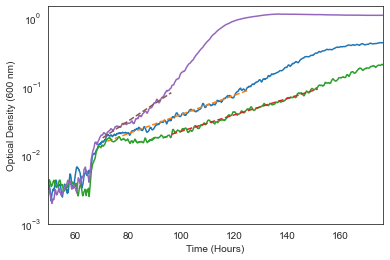

In [7]:
# Calculate and plot a maximal growth rate for the experimental tubes
plt.figure()
plt.yscale('log')

for name, key in bioreactor_mapping.items():
    if not name.startswith('recon'):
        continue        
    print(name)

    my_tube = bioreactor_continuous_df[bioreactor_continuous_df['key'] == key]

    # Note -- important to blank and blanking makes a big difference here. 
    times = my_tube.time.values
    ods = pd.Series(my_tube.value.values, dtype='float')
    blanked_ods = ods - ods[:10].mean()
    median_filtered_ods = blanked_ods.rolling(5).median()
    smoothed_ods = median_filtered_ods.rolling(10).mean()

    mask = np.logical_and(smoothed_ods > 2e-2, smoothed_ods < 0.1)
    log_ods = np.log(smoothed_ods[mask])
    matching_times = times[mask]

    res = stats.linregress(matching_times, log_ods)
    pred_log_OD = res.slope*matching_times + res.intercept
    pred_OD = np.exp(pred_log_OD)

    print('Predicted exponential growth rate %.2g /hr' % res.slope)
    dt_hrs = np.log(2)/res.slope
    print('Predicted doubling time %.2f hrs' % dt_hrs)

    # Add to plot
    plt.plot(times, smoothed_ods)
    plt.plot(matching_times, pred_OD, ls='--')

plt.xlim(50, 176)
plt.ylim(0.001, 1.5)
plt.xlabel('Time (Hours)')
plt.ylabel('Optical Density (600 nm)')

plt.show()

In [8]:
# Calculate the number of technical replicates in the plate reader endpoint data.
spark_endpoint_df.groupby(['sample', 'replicate']).count()

OD  well
sample     replicate          
Full CCM   rec.1      12    12
           rec.2      12    12
           rec.4      24    24
Neg.       K194.3     12    12
           K194.4     12    12
Rub. alone lsPrk.3    12    12
           lsPrk.4    12    12

In [9]:
# Bootstrapping (sampling w/ replacement) to get a confidence interval for
# the effect size from endpoint plate reader data at 80hrs.
full_ccm = spark_endpoint_df[spark_endpoint_df.replicate.isin(exp)]
rubisco_alone = spark_endpoint_df[spark_endpoint_df.replicate.isin(neg_exp)]
full_ccm_reps = full_ccm.groupby('replicate')
rubisco_alone_reps = rubisco_alone.groupby('replicate')

diff_of_means = []
for _ in range(int(1e4)):
    rep_means_ccm = []
    rep_means_rub_alone = []
    
    # subsample the technical replicates to 50%
    for gid, group in full_ccm_reps:
        n = group.index.size
        sub_idxs = np.random.choice(group.index, n//2, replace=True)
        rep_means_ccm.append(group.loc[sub_idxs].OD.mean())
    for gid, group in rubisco_alone_reps:
        n = group.index.size
        sub_idxs = np.random.choice(group.index, n//2, replace=True)
        rep_means_rub_alone.append(group.loc[sub_idxs].OD.mean())
    
    # Take the difference of the means of the technical replicate means
    dofm = np.mean(rep_means_ccm) - np.mean(rep_means_rub_alone)
    diff_of_means.append(dofm)

Mean difference between CCM and rubisco alone 0.6
99.9% confidence interval on the difference [0.56364684 0.63366961]


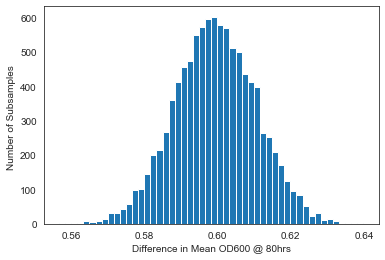

In [10]:
mean_diff = np.mean(diff_of_means)
print('Mean difference between CCM and rubisco alone %.1f' % mean_diff)
pctiles = np.percentile(diff_of_means, [0.05, 99.95])
print('99.9% confidence interval on the difference', pctiles)

plt.figure()
plt.hist(diff_of_means, bins=50)
plt.xlabel('Difference in Mean OD600 @ 80hrs')
plt.ylabel('Number of Subsamples ')

plt.show()